# 局部敏感度

```{admonition} 学习目标
阅读本章后，您将能够：
- 定义局部敏感度并解释其与全局敏感度的区别
- 描述局部敏感度是如何泄露数据信息的
- 使用"建议-测试-发布"框架来安全地使用局部敏感度
- 描述平滑敏感度框架
- 使用"采样-聚合"框架来回复敏感度为任意值的问询
```

截至目前，我们只学习了一种敏感度指标：全局敏感度。全局敏感度定义考察的是*任意*两个临近数据集。这种定义似乎显得过于严苛了。由于我们将在*实际*数据集上执行差分隐私机制，我们难道不应该只需要考虑*此*数据集的临近数据集吗？

*局部敏感度*（Local Sensitivity）{cite}`nissim2007`的直观思想是：将两个数据集中的一个作为待问询的*实际*数据集，仅考虑此数据集的所有临近数据集。用更严谨的数学语言来描述，函数$f : \mathcal{D} \rightarrow \mathbb{R}$在$x : \mathcal{D}$的局部敏感度定义如下：

\begin{align}
LS(f, x) = \max_{x': d(x,x') \leq 1} \lvert f(x) - f(x') \rvert
\end{align}

注意到，局部敏感度是以问询（$f$）和*实际*数据集（$x$）这两个输入定义的函数。与全局敏感度不同，我们不能抛开输入的数据集而单独讨论局部敏感度。反之，我们需要考虑局部敏感度*所依赖的*实际数据集是什么。

## 均值问询的局部敏感度

很难为一些函数设置全局敏感度的上界。此时，局部敏感度就可以被派上用场，以允许我们对这些函数设置有界的敏感度。均值函数就是一个典型的例子。截至目前，为了使均值问询满足差分隐私，我们需要将均值问询拆分为两个问询：满足差分隐私的求和问询（分子）和满足差分隐私的计数问询（分母）。应用串行组合性和后处理性，这两个问询结果的商仍然满足差分隐私。

我们为什么非要通过这种方式来回复均值问询呢？因为均值问询的输出结果*依赖于数据集的大小*。从数据集中增加或删除数据行，数据集的大小将随之变化，导致均值问询的输出结果发生变化。如果我们想计算均值问询的全局敏感度上界，我们就需要假设可能出现的最糟糕情况：数据集的大小为1。如果数据属性值的上下界分别为$u$和$l$，则均值的全局敏感度为$\lvert u - l \lvert$。对于较大规模的数据集来说，此全局敏感度上界是*极为*严苛的。与之相比，"噪声求和除以噪声计数"的问询回复方法要好得多。

局部敏感度定义下的情况就有所不同了。我们考虑最糟糕的情况：添加一个包含最大值（$u$）的新数据行。令$n = \lvert x \rvert$（即$n$表示数据集的大小）。我们先考虑实际数据集的均值：

\begin{align}
f(x) =& \frac{\sum_{i=1}^{n} x_i}{n}
\end{align}

现在，我们考虑添加一行后会发生什么：

\begin{align}
\lvert f(x') - f(x) \rvert = & \bigg\lvert \frac{\sum_{i=1}^{n} x_i + u}{n+1} - \frac{\sum_{i=1}^{n} x_i}{n} \bigg\rvert \\
\leq& \bigg\lvert \frac{\sum_{i=1}^{n} x_i + u}{n+1} - \frac{\sum_{i=1}^{n} x_i}{n+1} \bigg\rvert \\
=& \bigg\lvert \frac{\sum_{i=1}^{n} x_i + u - \sum_{i=1}^{n} x_i}{n+1}\bigg\rvert \\
=& \bigg\lvert \frac{u}{n+1} \bigg\rvert \\
\end{align}

此问询的局部敏感度依赖于实际数据集的大小，而全局敏感度的定义不可能与数据集本身相关。

## 通过局部敏感度实现差分隐私？

我们已经定义了一种新的敏感度指标，但我们该如何使用它呢？我们可以像全局敏感度那样直接使用拉普拉斯机制吗？以下对$F$的定义满足$\epsilon$-差分隐私性吗？

\begin{align}
F(x) = f(x) + \mathsf{Lap}\left(\frac{LS(f,x)}{\epsilon}\right)
\end{align}

不满足！很不幸，答案是否定的。由于$LS(f, x)$本身与数据集相关，如果分析者知道某个问询在*特定数据集*下的局部敏感度，那么分析者也许能够推断出一些与数据集相关的信息。因此，*不可能*直接使用局部敏感度来满足差分隐私。举例来说，考虑前面定义的均值问询局部敏感度边界。如果我们知道特定数据集$x$的局部敏感度，我们就可以推断出*没有噪声*的情况下数据集$x$的准确行数：

\begin{align}
\lvert x \rvert = \frac{b}{LS(f, x)} - 1
\end{align}

即使局部敏感度的取值对分析者保密也*无济于事*。分析者通过观察少量问询的回复就可能确定噪声尺度，从而使用该值推断出局部敏感度。差分隐私旨在保护$f(x)$的输出，但*并不能*保护差分隐私定义中所使用的敏感度指标。

学者们已经提出了几种安全使用局部敏感度的方法。我们将在本章剩余部分展开讨论。

In [8]:
%matplotlib inline
from mplfonts.bin.cli import init
init()
from mplfonts import use_font
use_font('SimHei')
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy as np

adult = pd.read_csv("adult_with_pii.csv")
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0


辅助数据可以向我们透露出一些非常敏感的信息。试想一下，如果我们的问询是："数据集中名叫Joe的人的平均成绩排名位于班级前2%吗？"，用于计算平均值的数据集大小就变得非常敏感了！！

### "建议-测试-发布"框架

局部敏感度的主要问题是敏感度本身会泄露数据的一些信息。如果我们让*敏感度本身*也满足差分隐私呢？直接实现这一目标很有挑战，因为一个函数局部敏感度的全局敏感度是无上界的。不过，我们可以通过提交满足差分隐私的问询来间接得到某个函数的局部敏感度。

"*建议-测试-发布*"（Propose-Test-Release）框架{cite}`dwork2009`采用的就是此种方法。该框架首先询问数据分析者函数的*建议*（Propose）局部敏感度上界。随后，该框架执行满足差分隐私的*测试*（Test），检验所问询的数据集是否"远离"了局部敏感度高于建议边界的数据集。如果测试通过，该框架*发布*（Release）噪声结果，并将噪声量校准到建议的边界。

为了回答一个数据集是否"远离"了有着更高局部敏感度数据集的问题，我们定义$k$*距离局部敏感度*的概念。我们用$A(f, x, k)$表示通过从数据集$x$执行$k$步可得到$f$的最大局部敏感度。用数学语言描述，我们有：

\begin{align}
A(f,x,k) = \max_{y: d(x,y) \leq k} LS(f, y)
\end{align}

现在，我们准备定义一个问询来回答以下问题："需要多少步才能实现比给定上界$b$更大的局部敏感度？"

\begin{align}
D(f, x, b) = \text{argmin}_k A(f, x, k) > b
\end{align}

最后，我们定义"建议-测试-发布"框架（详见[Barthe等人的论文](https://arxiv.org/abs/1407.2988)，图10），其满足$(\epsilon, \delta)$-差分隐私性：

1. 建议一个局部敏感度的目标边界$b$。
2. 如果$D(f, x, b) + \mathsf{Lap}(\frac{1}{\epsilon}) < \frac{\log(2/\delta)}{2\epsilon}$，返回$\bot$。
3. 否则，返回$f(x)+Lap(\frac{b}{\epsilon})$

注意到$D(f,x,b)$的*全局*敏感度为1：向$x$添加或移除一行都可能导致距离变化为到比当前局部敏感度"高"了1。因此，添加尺度为$\frac{1}{\epsilon}$的拉普拉斯噪声可以得到一种度量局部敏感度的差分隐私方法。

为什么该方法满足$(\epsilon, \delta)$-差分隐私（而不是纯粹$\epsilon$-差分隐私）呢？这是存在*偶然通过测试*的可能性，且出现概率不为零。即使$D(f,x,b)$的真实值*小于*满足差分隐私所需的最小距离，但在第2步添加的噪声可能非常大，以至于可以直接通过测试。

此失败方式更接近于我们在"灾难机制"中看到的灾难性失败方式，虽然仍然满足差分隐私，但"建议-测试-发布"框架允许有非0的概率发布包含*极小*噪声的问询结果。另一方面，"建议-测试-发布"框架并不像灾难机制那么糟糕，因为其永远不会发布*没有*噪声的问询结果。

另外需要注意的是，即使返回值是$\bot$，此框架的隐私消耗量仍然为$(\epsilon, \delta)$（也就是说，无论分析者是否收到了有意义的问询回复，此框架都会带来隐私消耗）。

让我们来实现均值问询的"建议-测试-发布"框架吧。回想一下，该问询的局部敏感度是$\big\lvert \frac{u}{n+1}\big\rvert$；提高此局部敏感度的最好方法是减小$n$。如果我们以数据集$x$为出发点执行$k$步，得到的局部敏感度就会变为$\big\lvert \frac{u}{(n-k)+1}\big\rvert$。我们使用如下Python代码实现该框架。

In [3]:
def ls_at_distance(df, u, k):
    return np.abs(u/(len(df) - k + 1))

def dist_to_high_ls(df, u, b):
    k = 0
    
    while ls_at_distance(df, u, k) < b:
        k += 1
    
    return k

In [16]:
def ptr_avg(df, u, b, epsilon, delta, logging=False):
    df_clipped = df.clip(upper=u)
    k = dist_to_high_ls(df_clipped, u, b)

    noisy_distance = laplace_mech(k, 1, epsilon)
    threshold = np.log(2/delta)/(2*epsilon)

    if logging:
        print(f"噪声距离为{noisy_distance}，而门限值为{threshold}")

    if noisy_distance >= threshold:
        return laplace_mech(df_clipped.mean(), b, epsilon)
    else:
        return None

In [11]:
df = adult['Age']
u = 100                    # 设置年龄的上界为100
epsilon = 1                # 设置ε = 1
delta = 1/(len(df)**2)     # 设置δ = 1/n^2
b = 0.005                  # 建议敏感度为0.005

ptr_avg(df, u, b, epsilon, delta, logging=True)

噪声距离为 12563.592689959718 而门限值为 10.73744412245554


38.5799843367179

请记住，局部敏感度并不总优于全局敏感度。对于均值问询，我们用旧回复策略得到的回复效果一般会好得多。这是因为我们可以将均值问询拆分为两个独立的、全局敏感度均有界的问询（求和与计数）。我们同样可以应用全局敏感度实现均值问询。

In [12]:
def gs_avg(df, u, epsilon):
    df_clipped = df.clip(upper=u)
    
    noisy_sum = laplace_mech(df_clipped.sum(), u, .5*epsilon)
    noisy_count = laplace_mech(len(df_clipped), 1, .5*epsilon)
    
    return noisy_sum / noisy_count

In [13]:
gs_avg(adult['Age'], u, epsilon)

38.567080384388845

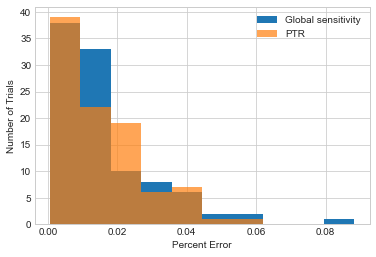

In [17]:
gs_results  = [pct_error(np.mean(adult['Age']), gs_avg(df, u, epsilon)) for i in range(100)]
ptr_results = [pct_error(np.mean(adult['Age']), ptr_avg(df, u, b, epsilon, delta)) for i in range(100)]

_, bins, _ = plt.hist(gs_results, label='全局敏感度');
plt.hist(ptr_results, alpha=.7, label='"建议-测试-发布"框架', bins=bins);
plt.xlabel('误差率')
plt.ylabel('尝试次数')
plt.legend();

使用"建议-测试-发布"框架的问询回复效果似乎更好一些，但实际上效果并没有太大的区别。此外，为使用"建议-测试-发布"框架，分析者必须建议一个敏感度边界。我们这里其实作了个弊，"神奇地"选择了一个非常合适的值（0.005）。事实上，分析者需要执行多次问询才能猜出可用的边界，而这一过程会消耗额外的隐私预算。

## 平滑敏感度

第二种使用局部敏感度的方法称为*平滑敏感度*（Smooth Sensitivity），来自[Nissim、Raskhodnikova和Smith的论文](http://www.cse.psu.edu/~ads22/pubs/NRS07/NRS07-full-draft-v1.pdf) {cite}`nissim2007`。利用拉普拉斯噪声实例化得到的*平滑敏感度框架*可提供$(\epsilon, \delta)$-差分隐私性：

1. 设置$\beta = \frac{\epsilon}{2\log(2/\delta)}$
2. 令$S = \max_{k = 1, \dots, n} e^{-\beta k} A(f, x, k)$
3. 发布$f(x) + \mathsf{Lap}\left(\frac{2S}{\epsilon}\right)$

平滑敏感度的基本思想是不使用局部敏感度本身，而是使用局部敏感度的"平滑"近似值来校准噪声。使用平滑量的目的就是要防止因直接使用局部敏感度而意外发布数据集的有关信息。上述步骤2就是在执行平滑操作：利用临近数据集与实际数据集距离的指数函数来缩放局部敏感度，并取缩放程度最大的结果作为最终的局部敏感度。这样做的效果是，如果$x$的临近数据集存在局部敏感度峰值，那么该峰值将作用于$x$的平滑敏感度中（因此，峰值本身被"平滑"了，不会泄露数据集的任何信息）。

与"建议-测试-发布"框架相比，平滑敏感度拥有明显的优势：它不需要分析者建议敏感度边界。站在分析者的角度看，使用平滑敏感度和使用全局敏感度一样简单。但是，平滑敏感度有两个主要的缺点。第一，平滑敏感度通常比局部敏感度大（至少为2倍，详见步骤3），因此增加的噪声量可能会比"建议-测试-发布"等替代框架更大。第二，计算平滑敏感度时需要找到*所有*可能的$k$中最大的平滑敏感度，这可能涉及极大的计算开销。在多数情况下，可以证明只需要考虑少量的$k$值就足够了（对于多数问询函数，$e^{-\beta k}$的指数衰减效果会很快覆盖$A(f, x, k)$的增长效果）。然而，对于想使用平滑敏感度的*每一个*问询函数，我们都需要证明此函数只需要考虑少量的$k$值。

举例来说，考虑之前定义的均值问询的平滑敏感度。

Final sensitivity: 0.006142128861863522


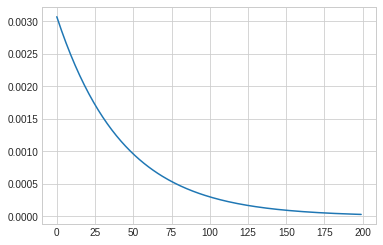

In [59]:
df = adult['Age']
epsilon = 1           # 设置ε = 1
delta = 1/len(df)**2  # 设置δ = 1/n^2

# 步骤1：设置β
beta = epsilon / (2*np.log(2/delta))

# 步骤2：对于不同的k值计算平滑后的局部敏感度
r = [np.exp(- beta * k) * ls_at_distance(df, u, k) for k in range(0,200)]
plt.plot(r);
plt.xlabel('k的取值')
plt.ylabel('平滑后的局部敏感度');

S = np.max(r)
sensitivity = 2*S
print(f'最终敏感度: {sensitivity}')

这里需要注意到两个现象。第一，即使只考虑$k$小于200的情况，我们也可以清楚地看到，均值问询平滑局部敏感度随着$k$的增加而趋近于0。事实上，$k=0$时的均值问询平滑局部敏感度取得最大值。在多数情况下，平滑局部敏感度都会随着$k$的增加而降低。但是，如果想要使用平滑敏感度，我们就必须*证明*它（这里我们并没有给出证明）。第二，注意到我们增加到问询结果中的最终噪声量*高于*我们之前（在"建议-测试-发布"框架中）建议的敏感度。尽管这两个噪声量的差距不大，但这也表明使用"建议-测试-发布"得到的局部敏感度有可能低于平滑敏感度。

## "采样-聚合"框架

我们接下来考虑与局部敏感度相关的最后一个框架，即"*采样-聚合*"（Sample and Aggregate）框架（同样来自[Nissim、Raskhodnikova和Smith的论文](http://www.cse.psu.edu/~ads22/pubs/NRS07/NRS07-full-draft-v1.pdf) {cite}`nissim2007`）。对任意函数$f : D \rightarrow \mathbb{R}$，令裁剪上界和下界分别为$u$和$l$，则下述框架满足$\epsilon$-差分隐私：

1. 将数据集$X \in D$拆分为$k$个不相交的数据块$x_1, \dots, x_k$
2. 计算每个数据块的裁剪回复值：$a_i = \max(l, \min(u, f(x_i)))$
3. 计算平均回复值并增加噪声：$A = \left(\frac{1}{k} \sum_{i=1}^k a_i \right) + \mathsf{Lap}\left(\frac{u - l}{k\epsilon}\right)$

注意，该框架满足纯粹$\epsilon$-差分隐私，且实际执行时无需使用局部敏感度。事实上，我们不需要知道关于$f$（无论是全局还是局部）敏感度的*任何*信息。除了知道每个数据块$x_i$互不相交外，我们也不需要知道$x_i$的任何其他信息。我们一般需要对数据集进行随机拆分（"好"的随机拆分结果往往会给出更准确的回复），但随机拆分并不是"采样-聚合"框架得以应用的必要条件。

仅仅利用全局敏感度和并行组合就可以证明该框架满足差分隐私。我们将数据集拆分为$k$个互不相交的数据块，因此每个个体仅出现在一个数据块中。我们不知道$f$的敏感度，但我们将其输出裁剪到$u$和$l$的范围内。因此，每个裁剪回复值$f(x_i)$的敏感度为$u-l$。由于我们调用了$k$次$f$，并取$k$次回复的平均值，因此均值的全局敏感度为$\frac{u-l}{k}$。

请注意，我们在"采样-聚合"框架中*直接*声明了均值的全局敏感度边界，并没有将均值拆分为求和问询与计数问询。我们无法对"常规"均值问询执行此操作，因为"常规"均值问询中计算平均数的分母与数据集大小相关。在"采样-聚合"框架中，计算平均数的分母由分析者所选择的$k$确定，$k$的取值与数据集无关。当均值问询中计算平均数的分母可以独立确定并对外公开时，我们就可以放心地使用这一改进的全局敏感度边界。

在该"采样-聚合"框架的简单实例中，我们要求分析者提供每个$f(x_i)$输出的上界$u$和下界$l$。由于$u$和$l$可能依赖于$f$的定义，因此可能*极难*确定$u$和$l$的取值。例如，在计数问询中，$f$的输出与数据集直接相关。

学者们已经提出了更高级的"采样-聚合"框架实例化方法（[Nissim、Raskhodnikova和Smith在论文中](http://www.cse.psu.edu/~ads22/pubs/NRS07/NRS07-full-draft-v1.pdf)讨论了一部分实例化方法），通过利用局部敏感度避免分析者给出$u$和$l$。然而，很容易限制一些特定函数$f$的输出范围，这种情况下就可以直接使用"采样-聚合"框架。我们仍然以计算给定数据集的平均年龄为例。人口的平均年龄很大可能在20到80之间，因此设置$l=20$和$u=80$是合理的。这样一来，我们限制了数据集平均年龄问询的输出范围，从而可以直接使用"采样-聚合"框架。只要每个数据块$x_i$都能体现人口信息的群体特性，不会出现过于极端的情况，我们就可以放心大胆地限制输出范围，而不丢失过多的信息。

In [87]:
def f(df):
    return df.mean()

def saa_avg_age(k, epsilon, logging=False):
    df = adult['Age']
    
    # 计算每个数据块应包含的行数
    chunk_size = int(np.ceil(df.shape[0] / k))
    
    if logging:
        print(f'数据块大小: {chunk_size}')
        
    # 步骤1：将`df`拆分为数据块
    xs      = [df[i:i+chunk_size] for i in range(0,df.shape[0],chunk_size)]
    
    # 步骤2：在每个x_i上执行f，并裁剪输出值
    answers = [f(x_i) for x_i in xs]
    
    u = 80
    l = 20
    clipped_answers = np.clip(answers, l, u)
    
    # 步骤3：计算输出均值，并增加噪声
    noisy_mean = laplace_mech(np.mean(clipped_answers), (u-l)/k, epsilon)
    return noisy_mean

saa_avg_age(600, 1, logging=True)

Chunk size: 55


38.617330607992074

该框架的关键参数是数据块数量，即$k$的取值。一方面，$k$越大，噪声均值的敏感度就越*小*。因此数据块数量越多，噪声量越小。另一方面，$k$越大，每个数据块就越*小*，因此每个回复值$f(x_i)$都越可能远离*正确*回复值$f(X)$。在上述例子中，我们希望每个数据块的平均年龄接近整个数据集的平均年龄。如果每个块只包含极少部分人，数据块的平均年龄很可能与数据集的平均年龄相差甚远。

我们应该如何设置$k$的值呢？这依赖于$f$和数据集本身，因此很难为数据集设置适当的$k$值。让我们尝试使用不同的$k$值来回复均值问询。

In [92]:
def plot_results(k):
    df = adult['Age']
    _, bins, _ = plt.hist([pct_error(np.mean(df), saa_avg_age(k, epsilon)) for i in range(100)]);
    plt.hist([pct_error(np.mean(df), gs_avg(df, u, epsilon)) for i in range(100)], alpha=.7, bins=bins);

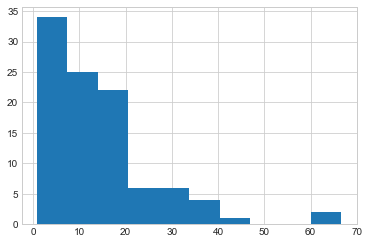

In [93]:
# k = 10；全局敏感度的回复结果准确性*非常*好
plot_results(10)
plt.xlabel('误差率')
plt.ylabel('尝试次数')

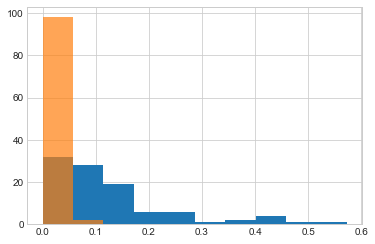

In [94]:
# k = 1000；全局敏感度的回复结果准确性仍然比较好
plot_results(1000)
plt.xlabel('误差率')
plt.ylabel('尝试次数')

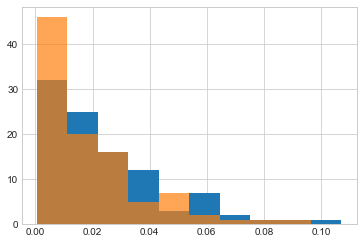

In [96]:
# k = 6000；"采样-聚合"框架的回复结果接近全局敏感度的回复结果了！
plot_results(6000)
plt.xlabel('误差率')
plt.ylabel('尝试次数')

因此，尽管"采样-聚合"框架的准确性无法击败全局敏感度方法，但如果能选择合适的$k$，两者的回复效果也可以非常接近。"采样-聚合"框架最大的优势在于此框架适用于*任意*函数$f$。无论函数的敏感度是多少，都可以使用"采样-聚合"框架。这意味着只要$f$本身表现良好，就可以应用"采样-聚合"框架获得$f$满足差分隐私的输出，并得到较好的准确度。另一方面，"采样-聚合"框架要求分析者设置裁剪边界$u$和$l$，并设置数据块数量$k$。